In [ ]:
# !pip install xgboost openpyxl


In [1]:
# STEP 0: Mount Google Drive (only once per session)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# STEP 2: Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# STEP 3: Load your dataset
file_path = '../data/filtered_fever_data.xlsx'  # change this path to match your folder

# Load and map labels
df = pd.read_excel(file_path)
df = df[df['label'].isin(['SUPPORTS', 'REFUTES'])]
df['label'] = df['label'].map({'SUPPORTS': 0, 'REFUTES': 1})  # SUPPORTS = 0, REFUTES = 1



In [6]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['claim'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)


In [ ]:
# STEP 5: Function to run TF-IDF + XGBoost + Evaluation
def run_xgboost_with_tfidf(max_features=1000, n_estimators=50, max_depth=3):

    #TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train_text)
    X_test_vec = vectorizer.transform(X_test_text)

    #XGBoost Model
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0,
        n_estimators=n_estimators,
        max_depth=max_depth
    )
    model.fit(X_train_vec, y_train)

    #Predictions
    y_pred = model.predict(X_test_vec)
    y_prob = model.predict_proba(X_test_vec)[:, 1]  # Prob for REFUTES (class 1)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["SUPPORTS", "REFUTES"])
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Output
    print(f"Results for TF-IDF max_features={max_features}")
    print("Accuracy:", round(acc * 100, 2), "%")
    print("ROC AUC Score:", round(roc_auc, 4))
    print("\nClassification Report:\n", report)
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["SUPPORTS", "REFUTES"], yticklabels=["SUPPORTS", "REFUTES"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


📊 Results for TF-IDF max_features=1000
Accuracy: 81.6 %
ROC AUC Score: 0.769

Classification Report:
               precision    recall  f1-score   support

    SUPPORTS       0.80      0.99      0.89     16007
     REFUTES       0.91      0.36      0.51      5955

    accuracy                           0.82     21962
   macro avg       0.86      0.67      0.70     21962
weighted avg       0.83      0.82      0.79     21962

Confusion Matrix:
[[15799   208]
 [ 3832  2123]]


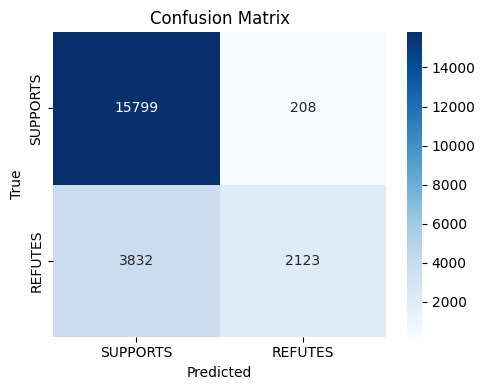

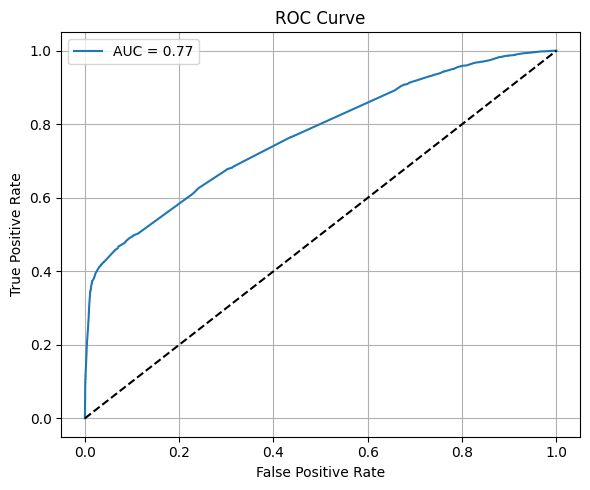

In [10]:
# STEP 6: Run baseline model
run_xgboost_with_tfidf(max_features=1000)


In [ ]:
# Variant 1: Handling Class Imbalance using scale_pos_weight
def run_xgboost_with_class_weight(max_features=1000, n_estimators=50, max_depth=3):
    # Calculate class weight using existing y_train
    from collections import Counter
    class_counts = Counter(y_train)
    neg, pos = class_counts[0], class_counts[1]
    weight = neg / pos

    print(f"Applying scale_pos_weight: {weight:.2f}")

    # TF-IDF
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train_text)
    X_test_vec = vectorizer.transform(X_test_text)

    #XGBoost with class weight
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0,
        n_estimators=n_estimators,
        max_depth=max_depth,
        scale_pos_weight=weight
    )
    model.fit(X_train_vec, y_train)

    # Predictions
    y_pred = model.predict(X_test_vec)
    y_prob = model.predict_proba(X_test_vec)[:, 1]  # probability for REFUTES = 1

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["SUPPORTS", "REFUTES"])
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"\nVariant 1 - XGBoost with Class Weight")
    print("Accuracy:", round(acc * 100, 2), "%")
    print("ROC AUC Score:", round(roc_auc, 4))
    print("\nClassification Report:\n", report)
    print("Confusion Matrix:")
    print(cm)

    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["SUPPORTS", "REFUTES"], yticklabels=["SUPPORTS", "REFUTES"])
    plt.title('Confusion Matrix (Class Weight)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Class Weight)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Applying scale_pos_weight: 2.69

📊 Variant 1 - XGBoost with Class Weight
Accuracy: 79.69 %
ROC AUC Score: 0.7705

Classification Report:
               precision    recall  f1-score   support

    SUPPORTS       0.82      0.92      0.87     16007
     REFUTES       0.68      0.47      0.56      5955

    accuracy                           0.80     21962
   macro avg       0.75      0.69      0.71     21962
weighted avg       0.78      0.80      0.78     21962

Confusion Matrix:
[[14709  1298]
 [ 3163  2792]]


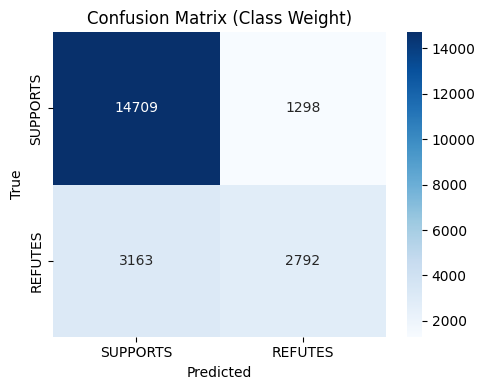

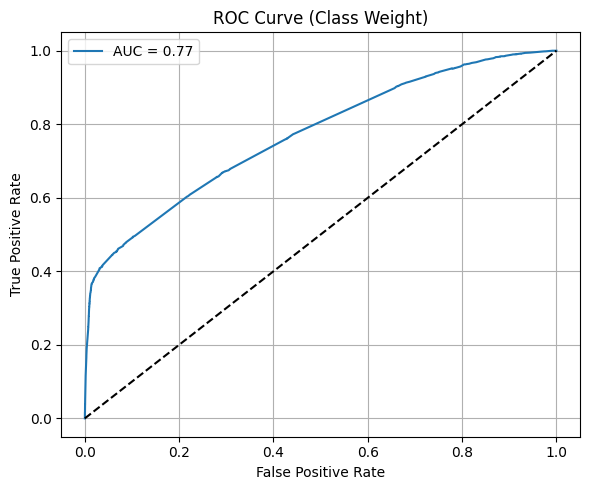

In [12]:
run_xgboost_with_class_weight(max_features=1000)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier

def run_grid_search_xgboost(max_features=1000):
    # Dynamically calculate scale_pos_weight
    class_counts = Counter(y_train)
    neg, pos = class_counts[0], class_counts[1]
    weight = neg / pos
    print(f"Applying scale_pos_weight: {weight:.2f}")

    # TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=max_features)

    # XGBoost model with class weight
    xgb = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0,
        scale_pos_weight=weight
    )

    # Pipeline: TF-IDF → XGBoost
    pipeline = Pipeline([
        ('tfidf', vectorizer),
        ('xgb', xgb)
    ])

    # Hyperparameter grid
    param_grid = {
        'xgb__n_estimators': [50, 100],
        'xgb__max_depth': [3, 5],
        'xgb__learning_rate': [0.1, 0.3]
    }

    # GridSearchCV with 3-fold cross-validation
    grid = GridSearchCV(
        pipeline,
        param_grid,
        scoring='f1_macro',
        cv=3,
        verbose=1,
        n_jobs=-1  # Use all available cores
    )

    # Run grid search
    grid.fit(X_train_text, y_train)

    # Output best results
    print("\n Best Parameters Found:")
    print(grid.best_params_)

    print("\n Best Cross-Validated F1 (macro):")
    print(round(grid.best_score_, 4))

    return grid


In [14]:
grid_result = run_grid_search_xgboost(max_features=1000)


Applying scale_pos_weight: 2.69
Fitting 3 folds for each of 8 candidates, totalling 24 fits

✅ Best Parameters Found:
{'xgb__learning_rate': 0.3, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}

📊 Best Cross-Validated F1 (macro):
0.7237


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_best_model(grid_result):
    # Get best pipeline (TF-IDF + XGBoost)
    best_model = grid_result.best_estimator_

    # 🔮 Predict on test set
    y_pred = best_model.predict(X_test_text)
    y_prob = best_model.predict_proba(X_test_text)[:, 1] 

    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["SUPPORTS", "REFUTES"])
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Print metrics
    print("Final Test Evaluation (Best GridSearch Model)")
    print("Accuracy:", round(acc * 100, 2), "%")
    print("ROC AUC Score:", round(roc_auc, 4))
    print("\nClassification Report:\n", report)
    print("Confusion Matrix:")
    print(cm)

    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["SUPPORTS", "REFUTES"],
                yticklabels=["SUPPORTS", "REFUTES"])
    plt.title('Confusion Matrix (Best Model)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # ROC Curve Plot
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Best Model)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


✅ Final Test Evaluation (Best GridSearch Model)
Accuracy: 78.99 %
ROC AUC Score: 0.8028

Classification Report:
               precision    recall  f1-score   support

    SUPPORTS       0.84      0.88      0.86     16007
     REFUTES       0.63      0.54      0.58      5955

    accuracy                           0.79     21962
   macro avg       0.73      0.71      0.72     21962
weighted avg       0.78      0.79      0.78     21962

Confusion Matrix:
[[14125  1882]
 [ 2733  3222]]


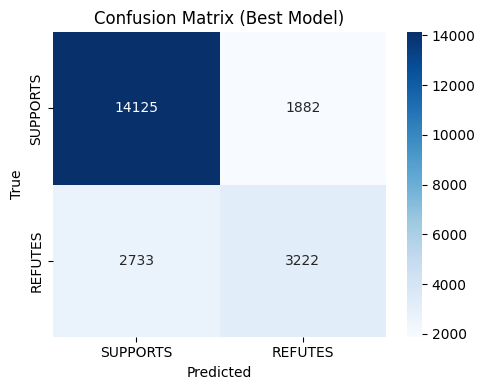

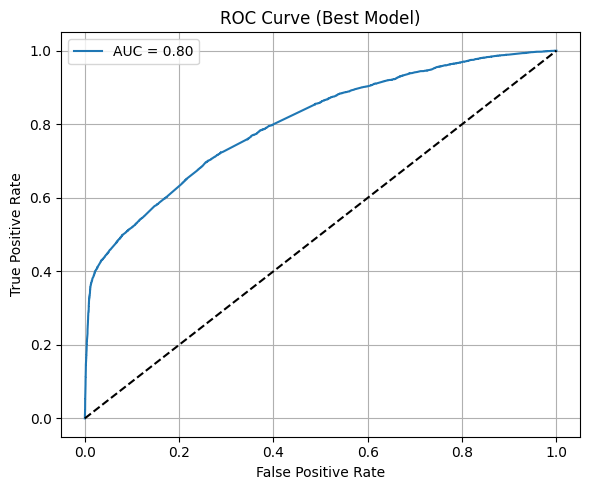

In [16]:
evaluate_best_model(grid_result)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from collections import Counter

def run_feature_size_experiments(feature_sizes=[500, 1000, 2000, 5000]):
    results = []

    # Dynamically compute scale_pos_weight from y_train
    counts = Counter(y_train)
    neg, pos = counts[0], counts[1]
    weight = neg / pos
    print(f"Using scale_pos_weight: {weight:.2f}")

    for max_feat in feature_sizes:
        print(f"\nTesting TF-IDF max_features = {max_feat}")

        # TF-IDF vectorization
        vectorizer = TfidfVectorizer(max_features=max_feat)
        X_train_vec = vectorizer.fit_transform(X_train_text)
        X_test_vec = vectorizer.transform(X_test_text)

        # XGBoost model with class weight
        model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            verbosity=0,
            learning_rate=0.3,
            max_depth=5,
            n_estimators=100,
            scale_pos_weight=weight
        )
        model.fit(X_train_vec, y_train)

        # Predictions
        y_pred = model.predict(X_test_vec)
        y_prob = model.predict_proba(X_test_vec)[:, 1]  # Prob for REFUTES = 1

        # Evaluation
        report = classification_report(
            y_test,
            y_pred,
            target_names=["SUPPORTS", "REFUTES"],
            output_dict=True,
            zero_division=0
        )
        auc = roc_auc_score(y_test, y_prob)

        results.append({
        'max_features': max_feat,
        'accuracy': report['accuracy'],
        'refutes_precision': report['REFUTES']['precision'],
        'refutes_recall': report['REFUTES']['recall'],
        'refutes_f1': report['REFUTES']['f1-score'],
        'auc': auc
    })

    return pd.DataFrame(results)


In [18]:
variant3_results = run_feature_size_experiments()
variant3_results


Using scale_pos_weight: 2.69

🔍 Testing TF-IDF max_features = 500

🔍 Testing TF-IDF max_features = 1000

🔍 Testing TF-IDF max_features = 2000

🔍 Testing TF-IDF max_features = 5000


,max_features,accuracy,refutes_precision,refutes_recall,refutes_f1,auc
0,500,0.781577,0.606044,0.555668,0.579763,0.796323
1,1000,0.789864,0.631270,0.541058,0.582693,0.802774
2,2000,0.807121,0.685197,0.534005,0.600227,0.813855
3,5000,0.810491,0.690948,0.544752,0.609202,0.816720


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_feature_size(max_features):
    print(f"\nEvaluating model with max_features = {max_features}")

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train_text)
    X_test_vec = vectorizer.transform(X_test_text)

    # Dynamically compute scale_pos_weight
    counts = Counter(y_train)
    neg, pos = counts[0], counts[1]
    weight = neg / pos
    print(f"Using scale_pos_weight: {weight:.2f}")

    # Train XGBoost
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0,
        learning_rate=0.3,
        max_depth=5,
        n_estimators=100,
        scale_pos_weight=weight
    )
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    y_prob = model.predict_proba(X_test_vec)[:, 1]

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["SUPPORTS", "REFUTES"])
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print("Accuracy:", round(acc * 100, 2), "%")
    print("ROC AUC Score:", round(roc_auc, 4))
    print("\nClassification Report:\n", report)
    print("Confusion Matrix:\n", cm)

    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["SUPPORTS", "REFUTES"],
                yticklabels=["SUPPORTS", "REFUTES"])
    plt.title(f'Confusion Matrix (max_features={max_features})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (max_features={max_features})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



🔍 Evaluating model with max_features = 5000
Using scale_pos_weight: 2.69
Accuracy: 81.05 %
ROC AUC Score: 0.8167

Classification Report:
               precision    recall  f1-score   support

    SUPPORTS       0.84      0.91      0.87     16007
     REFUTES       0.69      0.54      0.61      5955

    accuracy                           0.81     21962
   macro avg       0.77      0.73      0.74     21962
weighted avg       0.80      0.81      0.80     21962

Confusion Matrix:
 [[14556  1451]
 [ 2711  3244]]


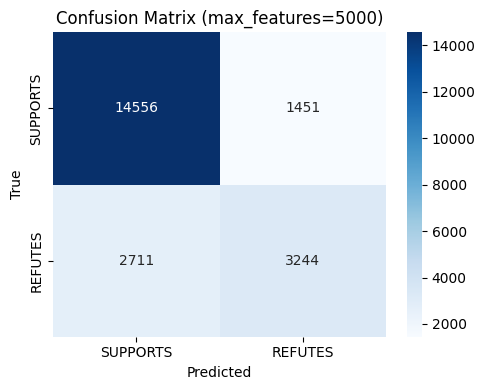

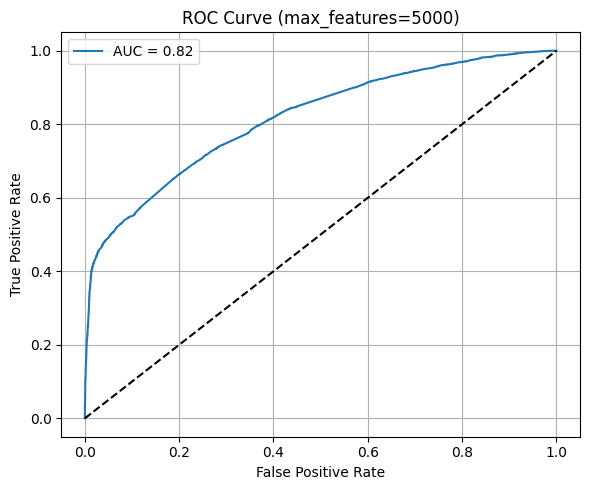

In [20]:

evaluate_feature_size(max_features=5000)
